In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
import re
import lfrData

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
G_lfr=nx.Graph()
data,labels=lfrData.load_data(0.3)

for index,item in enumerate(labels):
    G_lfr.add_node(index+1,value=item)
for item in data:
    G_lfr.add_edge(*item)
B_lfr = nx.modularity_matrix(G_lfr)

In [3]:
c_attributes = nx.get_node_attributes(G_lfr,'value')
print(c_attributes)

{1: 1, 2: 4, 3: 2, 4: 1, 5: 1, 6: 1, 7: 3, 8: 2, 9: 3, 10: 2, 11: 2, 12: 2, 13: 3, 14: 4, 15: 1, 16: 1, 17: 1, 18: 3, 19: 1, 20: 2, 21: 2, 22: 4, 23: 2, 24: 4, 25: 3, 26: 2, 27: 3, 28: 2, 29: 2, 30: 4, 31: 4, 32: 3, 33: 2, 34: 2, 35: 3, 36: 4, 37: 4, 38: 3, 39: 2, 40: 4, 41: 3, 42: 3, 43: 2, 44: 4, 45: 1, 46: 2, 47: 3, 48: 1, 49: 4, 50: 1, 51: 4, 52: 1, 53: 1, 54: 3, 55: 2, 56: 2, 57: 4, 58: 1, 59: 1, 60: 4, 61: 3, 62: 4, 63: 2, 64: 2, 65: 2, 66: 4, 67: 2, 68: 2, 69: 4, 70: 3, 71: 1, 72: 3, 73: 1, 74: 3, 75: 2, 76: 4, 77: 1, 78: 2, 79: 3, 80: 3, 81: 2, 82: 2, 83: 4, 84: 3, 85: 4, 86: 4, 87: 1, 88: 1, 89: 1, 90: 3, 91: 3, 92: 4, 93: 3, 94: 4, 95: 3, 96: 2, 97: 2, 98: 1, 99: 1, 100: 3, 101: 1, 102: 3, 103: 4, 104: 1, 105: 1, 106: 4, 107: 2, 108: 3, 109: 1, 110: 2, 111: 1, 112: 4, 113: 3, 114: 4, 115: 1, 116: 1, 117: 2, 118: 1, 119: 4, 120: 4, 121: 3, 122: 3, 123: 1, 124: 3, 125: 4, 126: 4, 127: 3, 128: 4}


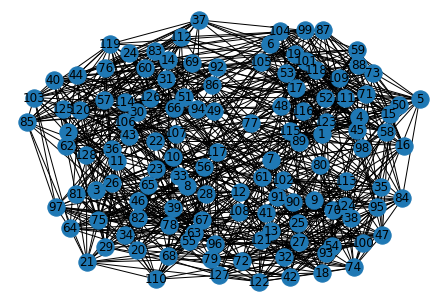

In [4]:
nx.draw(G_lfr,with_labels=True)

In [5]:
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [6]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.01)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        return encoder,reconstructed

In [7]:
learning_rate = 1e-3

In [8]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=64,in_layers=128)
model2=AE(hidden_layers=32,in_layers=64)
model3=AE(hidden_layers=16,in_layers=32)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model1)
print(model2)
print(model3)

AE(
  (encoder_hidden_layer): Linear(in_features=128, out_features=64, bias=True)
  (encoder_output_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_output_layer): Linear(in_features=64, out_features=128, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=64, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=64, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)


In [9]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [10]:
B_lfr=np.asarray(B_lfr,dtype=np.float64)
inputs=torch.from_numpy(B_lfr)
targets=torch.from_numpy(B_lfr)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist=train_model(300,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist=train_model(200,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
encoder,hist=train_model(300,train_dl,model3,optimizer3)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

epoch : 1/300, recon loss = 0.11718780
epoch : 2/300, recon loss = 0.11535350
epoch : 3/300, recon loss = 0.11369341
epoch : 4/300, recon loss = 0.11217326
epoch : 5/300, recon loss = 0.11076172
epoch : 6/300, recon loss = 0.10943111
epoch : 7/300, recon loss = 0.10815790
epoch : 8/300, recon loss = 0.10692268
epoch : 9/300, recon loss = 0.10570988
epoch : 10/300, recon loss = 0.10450738
epoch : 11/300, recon loss = 0.10330624
epoch : 12/300, recon loss = 0.10210048
epoch : 13/300, recon loss = 0.10088703
epoch : 14/300, recon loss = 0.09966575
epoch : 15/300, recon loss = 0.09843938
epoch : 16/300, recon loss = 0.09721327
epoch : 17/300, recon loss = 0.09599481
epoch : 18/300, recon loss = 0.09479249
epoch : 19/300, recon loss = 0.09361455
epoch : 20/300, recon loss = 0.09246757
epoch : 21/300, recon loss = 0.09135531
epoch : 22/300, recon loss = 0.09027857
epoch : 23/300, recon loss = 0.08923602
epoch : 24/300, recon loss = 0.08822560
epoch : 25/300, recon loss = 0.08724573
epoch : 2

In [11]:
B_lfr_X=encoder.detach().numpy()

In [12]:
print(type(B_lfr_X),B_lfr_X)

<class 'numpy.ndarray'> [[ 0.73823744  0.33079547 -0.3589364  ... -0.4626091  -0.6574203
  -0.13827078]
 [ 0.36388963 -0.54744405 -0.06429081 ... -0.4891251   0.5683623
  -0.29280758]
 [ 0.0819913  -0.39528325 -0.24659194 ...  0.17281394  0.01571498
  -0.11905908]
 ...
 [ 0.10202802 -0.51240844  0.16816838 ... -0.5735539   0.35001266
  -0.45004058]
 [-0.6326615  -0.08072753  0.25019145 ...  0.11681189  0.6701087
  -0.35748583]
 [-0.3332385  -0.39595032  0.43849573 ... -0.7268138   0.20996317
  -0.38100827]]


In [15]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=746)
kmeans.fit(B_lfr_X)
X_ae = kmeans.labels_

c_groups=[]
c_attributes = nx.get_node_attributes(G_lfr,'value')
for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[3 1 2 3 3 3 0 2 1 2 2 2 0 1 3 3 3 0 3 2 2 1 2 1 0 2 0 2 2 1 1 0 2 2 1 1 1
 1 2 1 0 0 2 1 3 2 0 3 1 3 1 3 3 0 2 2 1 3 3 1 0 1 2 2 2 1 2 2 1 0 3 0 3 0
 2 1 3 2 1 0 2 2 1 0 1 1 3 3 3 0 0 1 0 1 0 2 2 3 3 0 3 0 1 3 3 1 2 0 3 2 3
 3 0 1 3 3 2 3 1 1 0 0 3 0 1 1 0 1]
[1 4 2 1 1 1 3 2 3 2 2 2 3 4 1 1 1 3 1 2 2 4 2 4 3 2 3 2 2 4 4 3 2 2 3 4 4
 3 2 4 3 3 2 4 1 2 3 1 4 1 4 1 1 3 2 2 4 1 1 4 3 4 2 2 2 4 2 2 4 3 1 3 1 3
 2 4 1 2 3 3 2 2 4 3 4 4 1 1 1 3 3 4 3 4 3 2 2 1 1 3 1 3 4 1 1 4 2 3 1 2 1
 4 3 4 1 1 2 1 4 4 3 3 1 3 4 4 3 4]


0.9057031461145457

In [14]:
max=0
index_max=0
for value in range(1,1000):
    kmeans = KMeans(init='k-means++',n_clusters=4,random_state=value)
    kmeans.fit(B_lfr_X)
    X_ae = kmeans.labels_

    c_groups=[]
    c_attributes = nx.get_node_attributes(G_lfr,'value')
    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
            
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print("Epoch:{}".format(value),index_max,max)

Epoch:1 1 0.767864115560735
Epoch:2 1 0.767864115560735
Epoch:3 3 0.7923624609268557
Epoch:4 3 0.7923624609268557
Epoch:5 3 0.7923624609268557
Epoch:6 3 0.7923624609268557
Epoch:7 3 0.7923624609268557
Epoch:8 3 0.7923624609268557
Epoch:9 3 0.7923624609268557
Epoch:10 3 0.7923624609268557
Epoch:11 3 0.7923624609268557
Epoch:12 12 0.8391725550685724
Epoch:13 12 0.8391725550685724
Epoch:14 12 0.8391725550685724
Epoch:15 12 0.8391725550685724
Epoch:16 12 0.8391725550685724
Epoch:17 12 0.8391725550685724
Epoch:18 12 0.8391725550685724
Epoch:19 12 0.8391725550685724
Epoch:20 12 0.8391725550685724
Epoch:21 12 0.8391725550685724
Epoch:22 12 0.8391725550685724
Epoch:23 12 0.8391725550685724
Epoch:24 24 0.8395888348117362
Epoch:25 24 0.8395888348117362
Epoch:26 24 0.8395888348117362
Epoch:27 24 0.8395888348117362
Epoch:28 24 0.8395888348117362
Epoch:29 24 0.8395888348117362
Epoch:30 24 0.8395888348117362
Epoch:31 24 0.8395888348117362
Epoch:32 24 0.8395888348117362
Epoch:33 24 0.8395888348117362